# 시세 DB 구축 및 시세 조회 API 개발
---
네이버 금융에서 매번 스크레이핑을 하여 종목분석을 하면 속도가 너무 느리기 때문에, 스크레이핑 내용들을 개인 DB에 저장하고 API를 만든다.

## 야후 파이낸스의 데이터의 문제점
---

In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


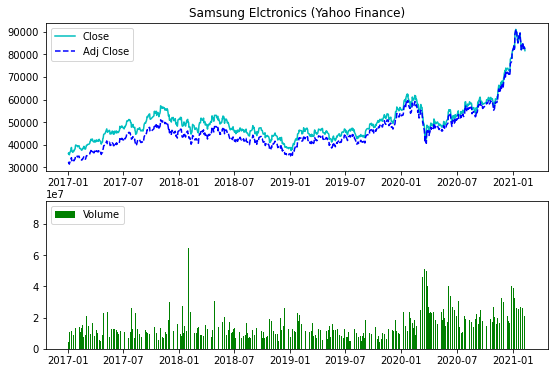

In [2]:
yf.pdr_override()

df = pdr.get_data_yahoo('005930.KS', '2017-01-01')

plt.figure(figsize=(9,6))
plt.subplot(2,1,1)
plt.title('Samsung Elctronics (Yahoo Finance)')
plt.plot(df.index, df['Close'], 'c', label='Close')
plt.plot(df.index, df['Adj Close'],'b--', label='Adj Close')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.bar(df.index, df['Volume'], color='g', label='Volume')
plt.legend(loc='best')
plt.show()

솔직히 문제점이 뭔지 잘 모르겠다. 작가피셜로는 2018년 5월 초에 삼성전자는 액면분할 이전의 종가는 250만원대로 표시되어야 한다고 한다.

2번째로는 2017년 10월에 3주가량의 데이터가 비었다고 하는데 솔직히 잘 모르겠다.

## 네이버 금융 데이터로 시세 데이터베이스 구축하기
---

책에서는 마리아디비를 깔고 로컬환경에서 진행을 하지만, Jupyter notebook을 사용하는 이상 로컬 환경에서 진행하는게 불가능하다(컴퓨터가 안좋기도 함) 그래서 책의 코드들을 참고하여 SqlLite를 이용한 API를 만들어보자

In [2]:
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request as urllib

In [4]:
class DBUpdater:
    def __init__(self):
        '''Create table'''
        self.conn = sqlite3.connect('investar.db')
        
        curs = self.conn.cursor()
        sql = '''
            CREATE TABLE IF NOT EXISTS company_info(
                code varchar(20),
                name varchar(40),
                last_update date,
                PRIMARY KEY (code)
            );
        '''
        curs.execute(sql)
        
        sql = '''
            CREATE TABLE IF NOT EXISTS daily_price(
                code varchar(20),
                date date,
                open bigint,
                high bigint,
                low bigint,
                close bigint,
                volume bigint,
                PRIMARY KEY(code, date)
            );
        '''
        curs.execute(sql)
        
        self.conn.commit()
        self.codes = dict()
        
    def __del__(self):
        '''Close connection'''
        self.conn.close()
        
    def read_krx_code(self):
        '''Read company informations from krx'''
        url = 'https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&pageIndex=1&currentPageSize=5000&comAbbrv=&beginIndex=&orderMode=3&orderStat=D&isurCd=&repIsuSrtCd=&searchCodeType=&marketType=&searchType=13&industry=&fiscalYearEnd=all&comAbbrvTmp=&location=all'
        krx = pd.read_html(url)[0]
        
        krx.dropna()
        krx = krx[['종목코드','회사명']]
        krx = krx.rename(columns={'종목코드':'code','회사명':'company'})
        krx.code = krx.code.map('{:06d}'.format)
        
        return krx
    
    